In [1]:
%run model.ipynb

/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/nd/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
model.ipynb:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
  "metadata": {},
model.ipynb:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
  "import pandas as pd\n",


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [2]:
import sys
sys.path.append('../preparations/')

In [3]:
# import x01_generate_notes
import x02_generate_midi
import x03_generate_wav
import x04_generate_wav_processed
import x05_generate_spectrogram
import x06_generate_label

In [4]:
!mkdir notes
!mkdir midi
!mkdir wav
!mkdir wav_processed
!mkdir spectrogram
!mkdir label
!rm ./notes/*
!rm ./midi/*
!rm ./wav/*
!rm ./wav_processed/*
!rm ./spectrogram/*
!rm ./label/*

mkdir: notes: File exists
mkdir: midi: File exists
mkdir: wav: File exists
mkdir: wav_processed: File exists
mkdir: spectrogram: File exists
mkdir: label: File exists


In [5]:
import numpy as np
import random

# this generates what time play what note and saves it to ./notes/

def generate_note_file():
    # could be summarised
    sound_id = ''.join(random.choice('0123456789ABCDEF') for i in range(16))
    
    # t = 2 means the 1st second, since the tempo is 120bpm.
    # this model does not assume any periodicity in transcription
    t = 0.1
    note_time_array = []
    
    chord_holder = []
    
    while t < 12:
        t += 0.25 + np.random.uniform(0,1.1)**5
        
        notes_in_this_chord = []
        
        if len(chord_holder) and np.random.uniform() > 0.75:
            notes_in_this_chord = chord_holder
            if np.random.uniform() < 1/len(chord_holder)**4:
                new_note = np.random.randint(24)
                if new_note not in notes_in_this_chord:
                    notes_in_this_chord.append(new_note)
        
        elif np.random.uniform() > 0.9:
            # generate one note
            new_note = np.random.randint(24)
            
        elif np.random.uniform() > 0.4 or t > 18:
            # random generation
            
            if np.random.uniform() > 0.2:
                new_note = np.random.randint(24)
                if new_note not in notes_in_this_chord:
                    notes_in_this_chord.append(new_note)

            if np.random.uniform() > 0.2:
                new_note = np.random.randint(24)
                if new_note not in notes_in_this_chord:
                    notes_in_this_chord.append(new_note)

            if np.random.uniform() > 0.3:
                new_note = np.random.randint(24)
                if new_note not in notes_in_this_chord:
                    notes_in_this_chord.append(new_note)

            if np.random.uniform() > 0.3:
                new_note = np.random.randint(24)
                if new_note not in notes_in_this_chord:
                    notes_in_this_chord.append(new_note)
                
        else:
            # favouring usual chords
            new_note = np.random.randint(24)
            notes_in_this_chord.append(new_note)
            
            if np.random.uniform() > 0.8:
                new_note = np.random.randint(24-7)
                notes_in_this_chord.append(new_note)
                notes_in_this_chord.append(new_note+3)
                notes_in_this_chord.append(new_note+7)
                
            elif np.random.uniform() > 0.8:
                new_note = np.random.randint(24-7)
                notes_in_this_chord.append(new_note)
                notes_in_this_chord.append(new_note+4)
                notes_in_this_chord.append(new_note+7)
                
            elif np.random.uniform() > 0.9:
                new_note = np.random.randint(24-7)
                notes_in_this_chord.append(new_note)
                notes_in_this_chord.append(new_note+3)
                notes_in_this_chord.append(new_note+6)
                
            elif np.random.uniform() > 0.9:
                new_note = np.random.randint(24-8)
                notes_in_this_chord.append(new_note)
                notes_in_this_chord.append(new_note+4)
                notes_in_this_chord.append(new_note+8)
                
            elif np.random.uniform() > 0.95:
                new_note = np.random.randint(24-12)
                notes_in_this_chord.append(new_note)
                notes_in_this_chord.append(new_note+3)
                notes_in_this_chord.append(new_note+7)
                notes_in_this_chord.append(new_note+7)
                
            elif np.random.uniform() > 0.95:
                new_note = np.random.randint(24-12)
                notes_in_this_chord.append(new_note)
                notes_in_this_chord.append(new_note+4)
                notes_in_this_chord.append(new_note+7)
                notes_in_this_chord.append(new_note+12)
                
            elif np.random.uniform() > 0.95:
                new_note = np.random.randint(24-12)
                notes_in_this_chord.append(new_note)
                notes_in_this_chord.append(new_note+3)
                notes_in_this_chord.append(new_note+6)
                notes_in_this_chord.append(new_note+12)
                
            elif np.random.uniform() > 0.95:
                new_note = np.random.randint(24-12)
                notes_in_this_chord.append(new_note)
                notes_in_this_chord.append(new_note+4)
                notes_in_this_chord.append(new_note+8)
                notes_in_this_chord.append(new_note+12)
                
            else:
                # generate one note
                new_note = np.random.randint(24)
                
        chord_holder = notes_in_this_chord
        for note in notes_in_this_chord:
            note_time_array.append([t, note])
            print(t)
            print(notes_in_this_chord)
                
#     print(note_time_array)
    print(np.shape(note_time_array))
    np.save("./notes/" + sound_id, np.array(note_time_array))

In [6]:
generate_note_file()

0.35500143254950955
[21, 22, 23]
0.35500143254950955
[21, 22, 23]
0.35500143254950955
[21, 22, 23]
0.6139656477728055
[21, 22, 23]
0.6139656477728055
[21, 22, 23]
0.6139656477728055
[21, 22, 23]
0.9360785732719379
[15]
1.677488219442479
[15, 12, 15, 19]
1.677488219442479
[15, 12, 15, 19]
1.677488219442479
[15, 12, 15, 19]
1.677488219442479
[15, 12, 15, 19]
2.0044358480346376
[15, 12, 15, 19]
2.0044358480346376
[15, 12, 15, 19]
2.0044358480346376
[15, 12, 15, 19]
2.0044358480346376
[15, 12, 15, 19]
2.2591246182299116
[15, 12, 15, 19]
2.2591246182299116
[15, 12, 15, 19]
2.2591246182299116
[15, 12, 15, 19]
2.2591246182299116
[15, 12, 15, 19]
2.513140131594765
[15, 0]
2.513140131594765
[15, 0]
2.8457417735237507
[5, 1, 14]
2.8457417735237507
[5, 1, 14]
2.8457417735237507
[5, 1, 14]
3.095799234946483
[20, 2]
3.095799234946483
[20, 2]
3.8052951357989158
[7, 10, 16, 14]
3.8052951357989158
[7, 10, 16, 14]
3.8052951357989158
[7, 10, 16, 14]
3.8052951357989158
[7, 10, 16, 14]
4.161181359962866
[

In [7]:
import glob

# for every (time-note) file in ./notes, generate .mid file 

notes = glob.glob("./notes/*.npy")
print(len(notes))

for filename in notes:
    sound_id = filename[-20:-4]
    time_note_array = np.load(filename)
    time_array, note_array = np.transpose(time_note_array)
    x02_generate_midi.generate_midi_file(sound_id, time_array, np.array(note_array, dtype=int))

1


In [8]:
import glob

# for every .mid file generate the .wav file with fluidsynth

notes = glob.glob("./midi/*")
print(len(notes))
for filename in notes:
    x03_generate_wav.convert_midi_to_signal(filename)

1


In [9]:
# for every .wav file do some processing and generate another .wav file

files = glob.glob('./wav/*')
save_location = './wav_processed/'
print(len(files))
for filename in files:
    x04_generate_wav_processed.process_wav(filename, save_location)

1


In [10]:
import soundfile as sf
import sounddevice as sd

audio, sr = sf.read(files[0])

sd.play(audio, samplerate=sr)

In [11]:
import glob
files = glob.glob('./wav_processed/*')
print(len(files))
for filename in files:
    x05_generate_spectrogram.generate_spectrogram(filename)

1


In [12]:
# import glob
# files = glob.glob('../*.wav')
# print(len(files))
# for filename in files:
#     x05_generate_spectrogram.generate_spectrogram(filename)

In [13]:
import soundfile as sf
import sounddevice as sd

audio, sr = sf.read(files[0])

sd.play(audio, samplerate=sr)

In [14]:
# for every time-note file .npy generate .npy labels

import glob

notes = glob.glob("./notes/*.npy")
print(len(notes))

for filename in notes:
#     sound_id = filename[-20:-4]
#     time_note_array = np.load(filename)
#     time_array, note_array = np.transpose(time_note_array)
    x06_generate_label.generate_label(filename)

1


In [15]:
!ls ./notes/
!ls ./midi/
!ls ./wav/
!ls ./wav_processed/
!ls ./spectrogram/
!ls ./label/

F8E66BD68780DBF4.npy
F8E66BD68780DBF4.mid
F8E66BD68780DBF4.wav
F8E66BD68780DBF4.wav
F8E66BD68780DBF4.npy
F8E66BD68780DBF4.npy


In [16]:
import glob
import matplotlib.pyplot as plt

glob_label = glob.glob('./label/*')
glob_spectrogram = glob.glob('./spectrogram/*')
glob_notes = glob.glob('./notes/*.npy')

./notes/F8E66BD68780DBF4.npy
(78, 2)


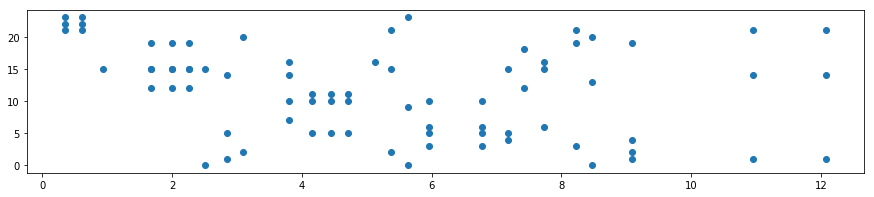

In [17]:
for notes_ in glob_notes:
    print(notes_)
    
    notes = np.load(notes_)
    
    print(np.shape(notes))
    plt.figure(figsize=(15,3))
    plt.scatter(notes[:,0],notes[:,1])
    plt.show()

./label/F8E66BD68780DBF4.npy
(184, 24)


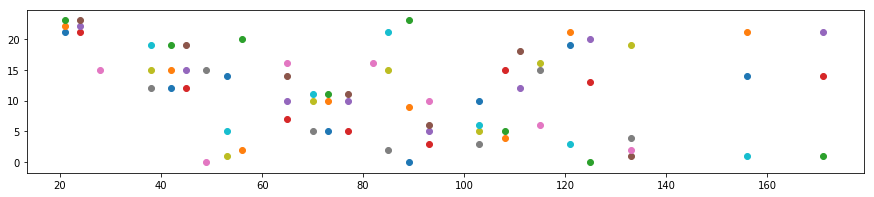

In [18]:
# plotting the labels to ensure that they are produced correctly

for label_ in glob_label:
    print(label_)
    
    label = np.load(label_)
    
    print(np.shape(label))
    plt.figure(figsize=(15,3))
    for i,time_slice in enumerate(label):
        for j,note in enumerate(time_slice):
            if note != 0:
                plt.scatter(i,j)
    plt.show()

In [19]:
def generate_random_cnn_lstm_input_and_target_label(spectrogram, label):
    print(np.shape(label))
    print(np.shape(spectrogram))
    length = np.shape(spectrogram)[1] - 108
    print(length)
    random_point = np.random.randint(0,length)
    print(random_point)

    cnn_input = spectrogram[:,random_point:random_point+108]
    lstm_input = label[random_point//27:random_point//27+20,:]
    target_label = label[random_point//27+20,:]
    
    plt.figure(figsize=(4,4))
    plt.imshow(cnn_input)
    plt.clim(0,0.4)
    plt.colorbar()
    plt.show()
    
    if random_point>17*27:
        spec_show = spectrogram[:,random_point-17*27:random_point+108]
        plt.figure(figsize=(21,4))
        plt.imshow(spec_show)
        plt.clim(0,0.5)
        plt.show()
    print("target_label: ")
    print(target_label)
    print("next two labels: ")
    print(label[random_point//27+21,:])
    print(label[random_point//27+22,:])
    
    label_show = label[random_point//27:random_point//27+22,:]
    plt.figure(figsize=(21,4))
    for i,time_slice in enumerate(label_show):
        for j,note in enumerate(time_slice):
            if note != 0:
                plt.scatter(i+1,j)
    plt.xlim(0, 21)
    plt.ylim(-1, 24)
    plt.show()
    
    return cnn_input, lstm_input, target_label


(184, 24)
(108, 4424)
4316
1308


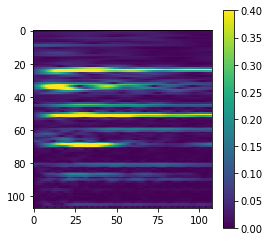

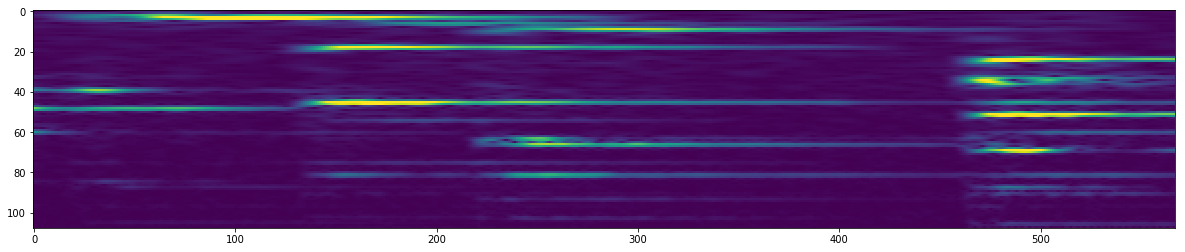

target_label: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
next two labels: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


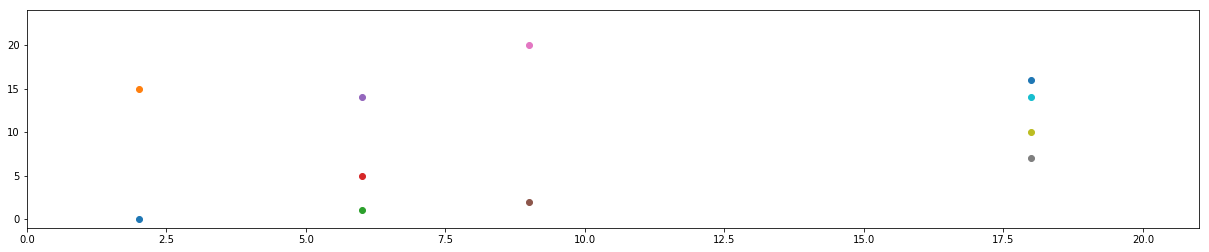

In [20]:
for spectrogram_,label_ in zip(glob_spectrogram,glob_label):
    
    spectrogram = np.load(spectrogram_)
    label = np.load(label_)
    cnn_input, lstm_input, target_label = generate_random_cnn_lstm_input_and_target_label(spectrogram,label)

(108, 4424)
(108, 4424)
(108, 1, 108, 160)
(160, 1, 108, 108)
(1, 108, 108)


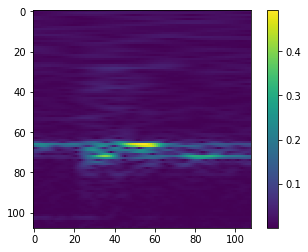

In [21]:
for spectrogram_ in glob_spectrogram:
    
    spectrogram = np.load(spectrogram_)
    
    print(np.shape(spectrogram))
    print(np.shape(spectrogram[:,:]))
    cnn_inputs = np.array(list(zip([spectrogram[:,i:-108+i:27] for i in range(108)])))
    print(np.shape(cnn_inputs))
    cnn_inputs = np.swapaxes(cnn_inputs,0,3)
    print(np.shape(cnn_inputs))
    cnn_inputs = [cnn_input for cnn_input in cnn_inputs]
    print(np.shape(cnn_inputs[1]))
    plt.imshow(cnn_inputs[7][0,:,:])
    plt.colorbar()
    plt.show()


(164, 1, 20, 24)


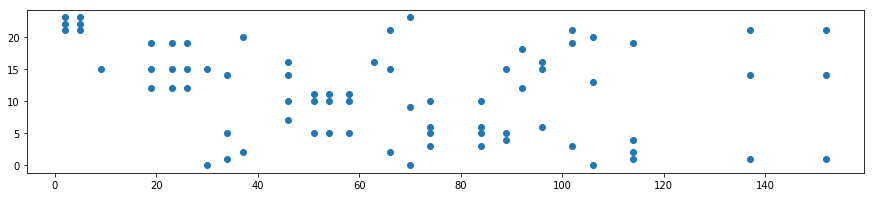

In [22]:
# loading the LSTM labels for comparison

for notes_, label_, spectrogram_ in zip(glob_notes, glob_label, glob_spectrogram):
    
    lstm_inputs = np.array(list(zip([label[i:-20+i] for i in range(20)])))
    lstm_inputs = np.swapaxes(lstm_inputs,0,2)
    print(np.shape(lstm_inputs))
    
    plt.figure(figsize=(15,3))
    ground_truth = []
    for i,lstm_input in enumerate(lstm_inputs):
        for time_slice in lstm_input[:,-1,:]:
            for j,note in enumerate(time_slice):
#                 print(note)
                if note != 0:
                    ground_truth.append((i,j))
    
    ground_truth = np.transpose(ground_truth)
    plt.scatter(ground_truth[:][0],ground_truth[:][1])
plt.show()

In [23]:
# transcription with the model

lstm_memory = np.zeros((1,20,24))
predicted_score = []

for i,cnn_input in enumerate(cnn_inputs):
    
#     print(np.shape(cnn_input))
#     print(np.shape(lstm_input))
#     give_prediction(classifier, np.zeros((1,20,24)), np.zeros((1,108,108,1)))
#     print(lstm_input[-1,-1])
#     print(result)
    result = give_prediction(classifier, lstm_memory, cnn_input.reshape((1,108,108,1)))
    lstm_memory[0,:-1] = np.copy(lstm_memory[0,1:])
    lstm_memory[0,-1] = np.copy(result)
    for j, note in enumerate(result[0]):
        if note != 0:
            predicted_score.append([i,j])
predicted_score = np.transpose(predicted_score)

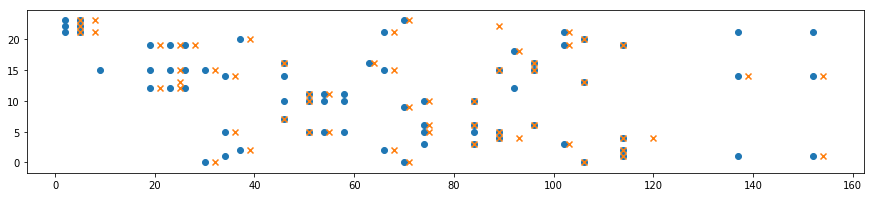

In [24]:
# compare result 
plt.figure(figsize=(15,3))
plt.scatter(ground_truth[0], ground_truth[1], marker='o')
plt.scatter(predicted_score[0], predicted_score[1], marker='x') # should -20      
plt.show()

In [25]:
# problem of the training inventising not to predict any notes rather than predict note at the wrong time
### exponential decaying labels
# the debate between onset only labels and label for the entire duration of the note
# 
# hk todo:
# create dataset, put online
# why is it predicting ahead of time? need to look at CNN output
# prolly make the hyperparameters variables 2**7, 108x108, 20x24 for different kind of training